In [64]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings
import regex
import sys, os

%matplotlib inline
warnings.filterwarnings('ignore')

In [65]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
    '12hr' : '%d/%m/%y, %I:%M %p - ',
    '24hr' : '%d/%m/%y, %H:%M - ',
    'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

def anonymize_usernames(df):
    '''Anonymizes the usernames and provides a mapping dictionary.'''
    
    username_mapping = {"group_notification": "group_notification"}
    next_id = 1
    
    def get_anonymized_username(username):
        nonlocal next_id
        if username not in username_mapping:
            anonymized_username = f"Anonymous User_{next_id}"
            username_mapping[username] = anonymized_username
            next_id += 1
        return username_mapping[username]
    
    df['user'] = df['user'].apply(get_anonymized_username)
    
    return df, username_mapping

def get_original_username(anonymized_username, mapping):
    '''Retrieves the original username from the mapping dictionary.'''
    for username, anon_username in mapping.items():
        if anon_username == anonymized_username:
            return username
    return None

# Example usage:
# df = rawToDf('path_to_your_whatsapp_chat.txt', '12hr')
# df, username_mapping = anonymize_usernames(df)

# Display the DataFrame
# print(df)

# Example to generate a graph:
# Let's say we want to plot the number of messages per user
# user_message_counts = df['user'].value_counts().sort_index()

# plt.figure(figsize=(10, 6))
# user_message_counts.plot(kind='bar')
# plt.xlabel('User (Anonymized ID)')
# plt.ylabel('Number of Messages')
# plt.title('Number of Messages per User')
# plt.show()


In [66]:
df = rawToDf(r'C:\Users\reddy\Downloads\WhatsApp Chat with Synolo Core Actives\WhatsApp Chat with Synolo Core Actives.txt', '12hr')

In [67]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  1310 non-null   datetime64[ns]
 1   user       1310 non-null   object        
 2   message    1310 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 30.8+ KB


In [68]:
df, username_mapping = anonymize_usernames(df)
df.sample(10)

date_time               user                        message
14   2023-09-23 01:31:00   Anonymous User_4       They’re releasing stuff 
688  2024-02-25 12:37:00  Anonymous User_16           If anyone disagrees 
879  2024-03-04 15:51:00   Anonymous User_3                   Music room? 
51   2023-09-24 13:18:00   Anonymous User_6                        bruhhh 
56   2023-09-24 13:19:00   Anonymous User_6                          yooo 
686  2024-02-25 12:37:00   Anonymous User_3  Drummer supremacy at the end 
1266 2024-04-01 12:46:00   Anonymous User_3                    Very alive 
756  2024-03-01 13:41:00   Anonymous User_5                   ok computer 
500  2024-02-25 12:07:00  Anonymous User_16    Oh that's what that is huh 
171  2024-01-22 18:45:00   Anonymous User_2                       Comers*

In [69]:
df[df['message'] == ""].shape[0]

10

In [70]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

In [44]:
df, username_mapping = anonymize_usernames(df)
df

date_time              user  \
0    2022-09-23 15:57:00  Anonymous User_1   
1    2022-09-23 15:57:00  Anonymous User_1   
2    2023-09-22 17:01:00  Anonymous User_2   
3    2023-09-22 17:01:00  Anonymous User_2   
4    2023-09-22 20:18:00  Anonymous User_2   
...                  ...               ...   
1305 2024-05-02 10:55:00  Anonymous User_7   
1306 2024-05-02 10:56:00  Anonymous User_4   
1307 2024-05-02 10:56:00  Anonymous User_6   
1308 2024-05-02 10:56:00  Anonymous User_4   
1309 2024-05-02 10:57:00  Anonymous User_9   

                                              message  day month  year  \
0        Karteek created group "Synolo Core Actives"   Fri   Sep  2022   
1                                     You were added   Fri   Sep  2022   
2     there's a performance for barbie x Oppenheimer   Fri   Sep  2023   
3                                                  ?   Fri   Sep  2023   
4                                              guys?   Fri   Sep  2023   
...                                               ...  ...   ...   ...   
1305                                              😂😂   Thu   May  2024   
1306                              I have no comments   Thu   May  2024   
1307                                go back to sleep   Thu   May  2024   
1308                                 <Media omitted>   Thu   May  2024   
1309                                 <Media omitted>   Thu   May  2024   

            date  
0     2022-09-23  
1     2022-09-23  
2     2023-09-22  
3     2023-09-22  
4     2023-09-22  
...          ...  
1305  2024-05-02  
1306  2024-05-02  
1307  2024-05-02  
1308  2024-05-02  
1309  2024-05-02  

[1310 rows x 7 columns]

In [53]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

date  message_count
0   2022-09-23              2
1   2023-09-22              6
2   2023-09-23             14
3   2023-09-24             41
4   2023-09-25              2
..         ...            ...
66  2024-04-01             27
67  2024-04-14              8
68  2024-04-25              6
69  2024-05-01              9
70  2024-05-02             16

[71 rows x 2 columns]

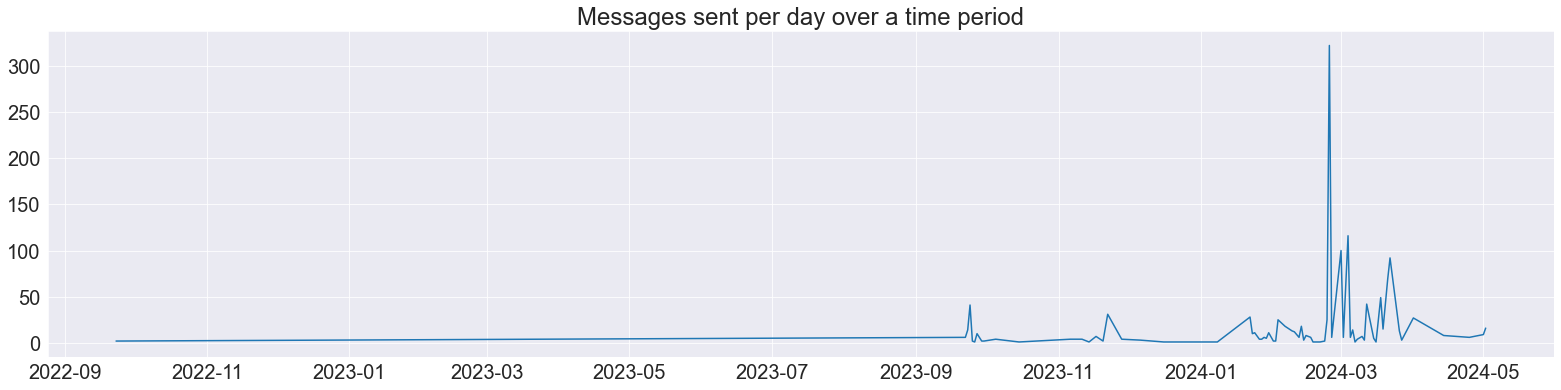

In [71]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

In [72]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

date  message_count
0  2024-02-25            322
1  2024-03-04            116
2  2024-03-01            100
3  2024-03-22             92
4  2024-03-21             69
5  2024-03-18             49
6  2024-03-12             42
7  2023-09-24             41
8  2023-11-22             31
9  2024-01-22             28

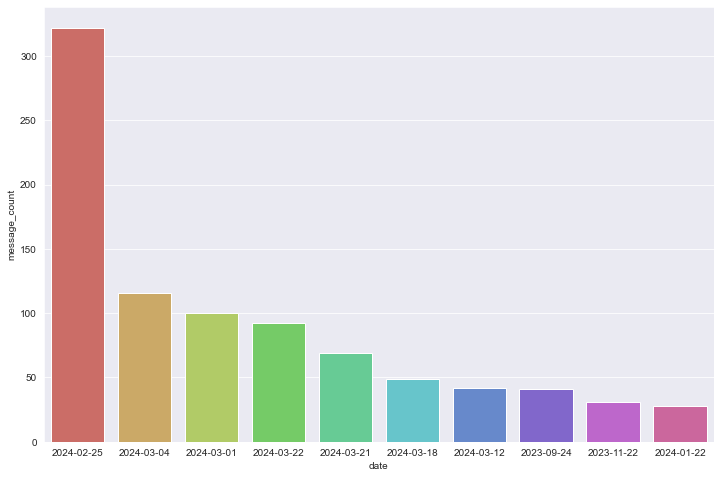

In [73]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(top10days.date, top10days.message_count, palette="hls");

# Saving the plots
plt.savefig('top10_days.svg', format = 'svg')


In [74]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 23
Number of people who haven't sent even a single message on the group are 212


In [75]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
df2, _ = anonymize_usernames(df2)
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

user  message
0   Anonymous User_6      286
1   Anonymous User_3      273
2  Anonymous User_16      140
3   Anonymous User_5      124
4   Anonymous User_2      106
5  Anonymous User_14       71
6   Anonymous User_8       54
7   Anonymous User_7       53
8  Anonymous User_18       28
9  Anonymous User_19       25

In [76]:
top10df['initials'] = ''
for i in range(len(top10df)):
    top10df.initials[i] = top10df.user[i]




In [78]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

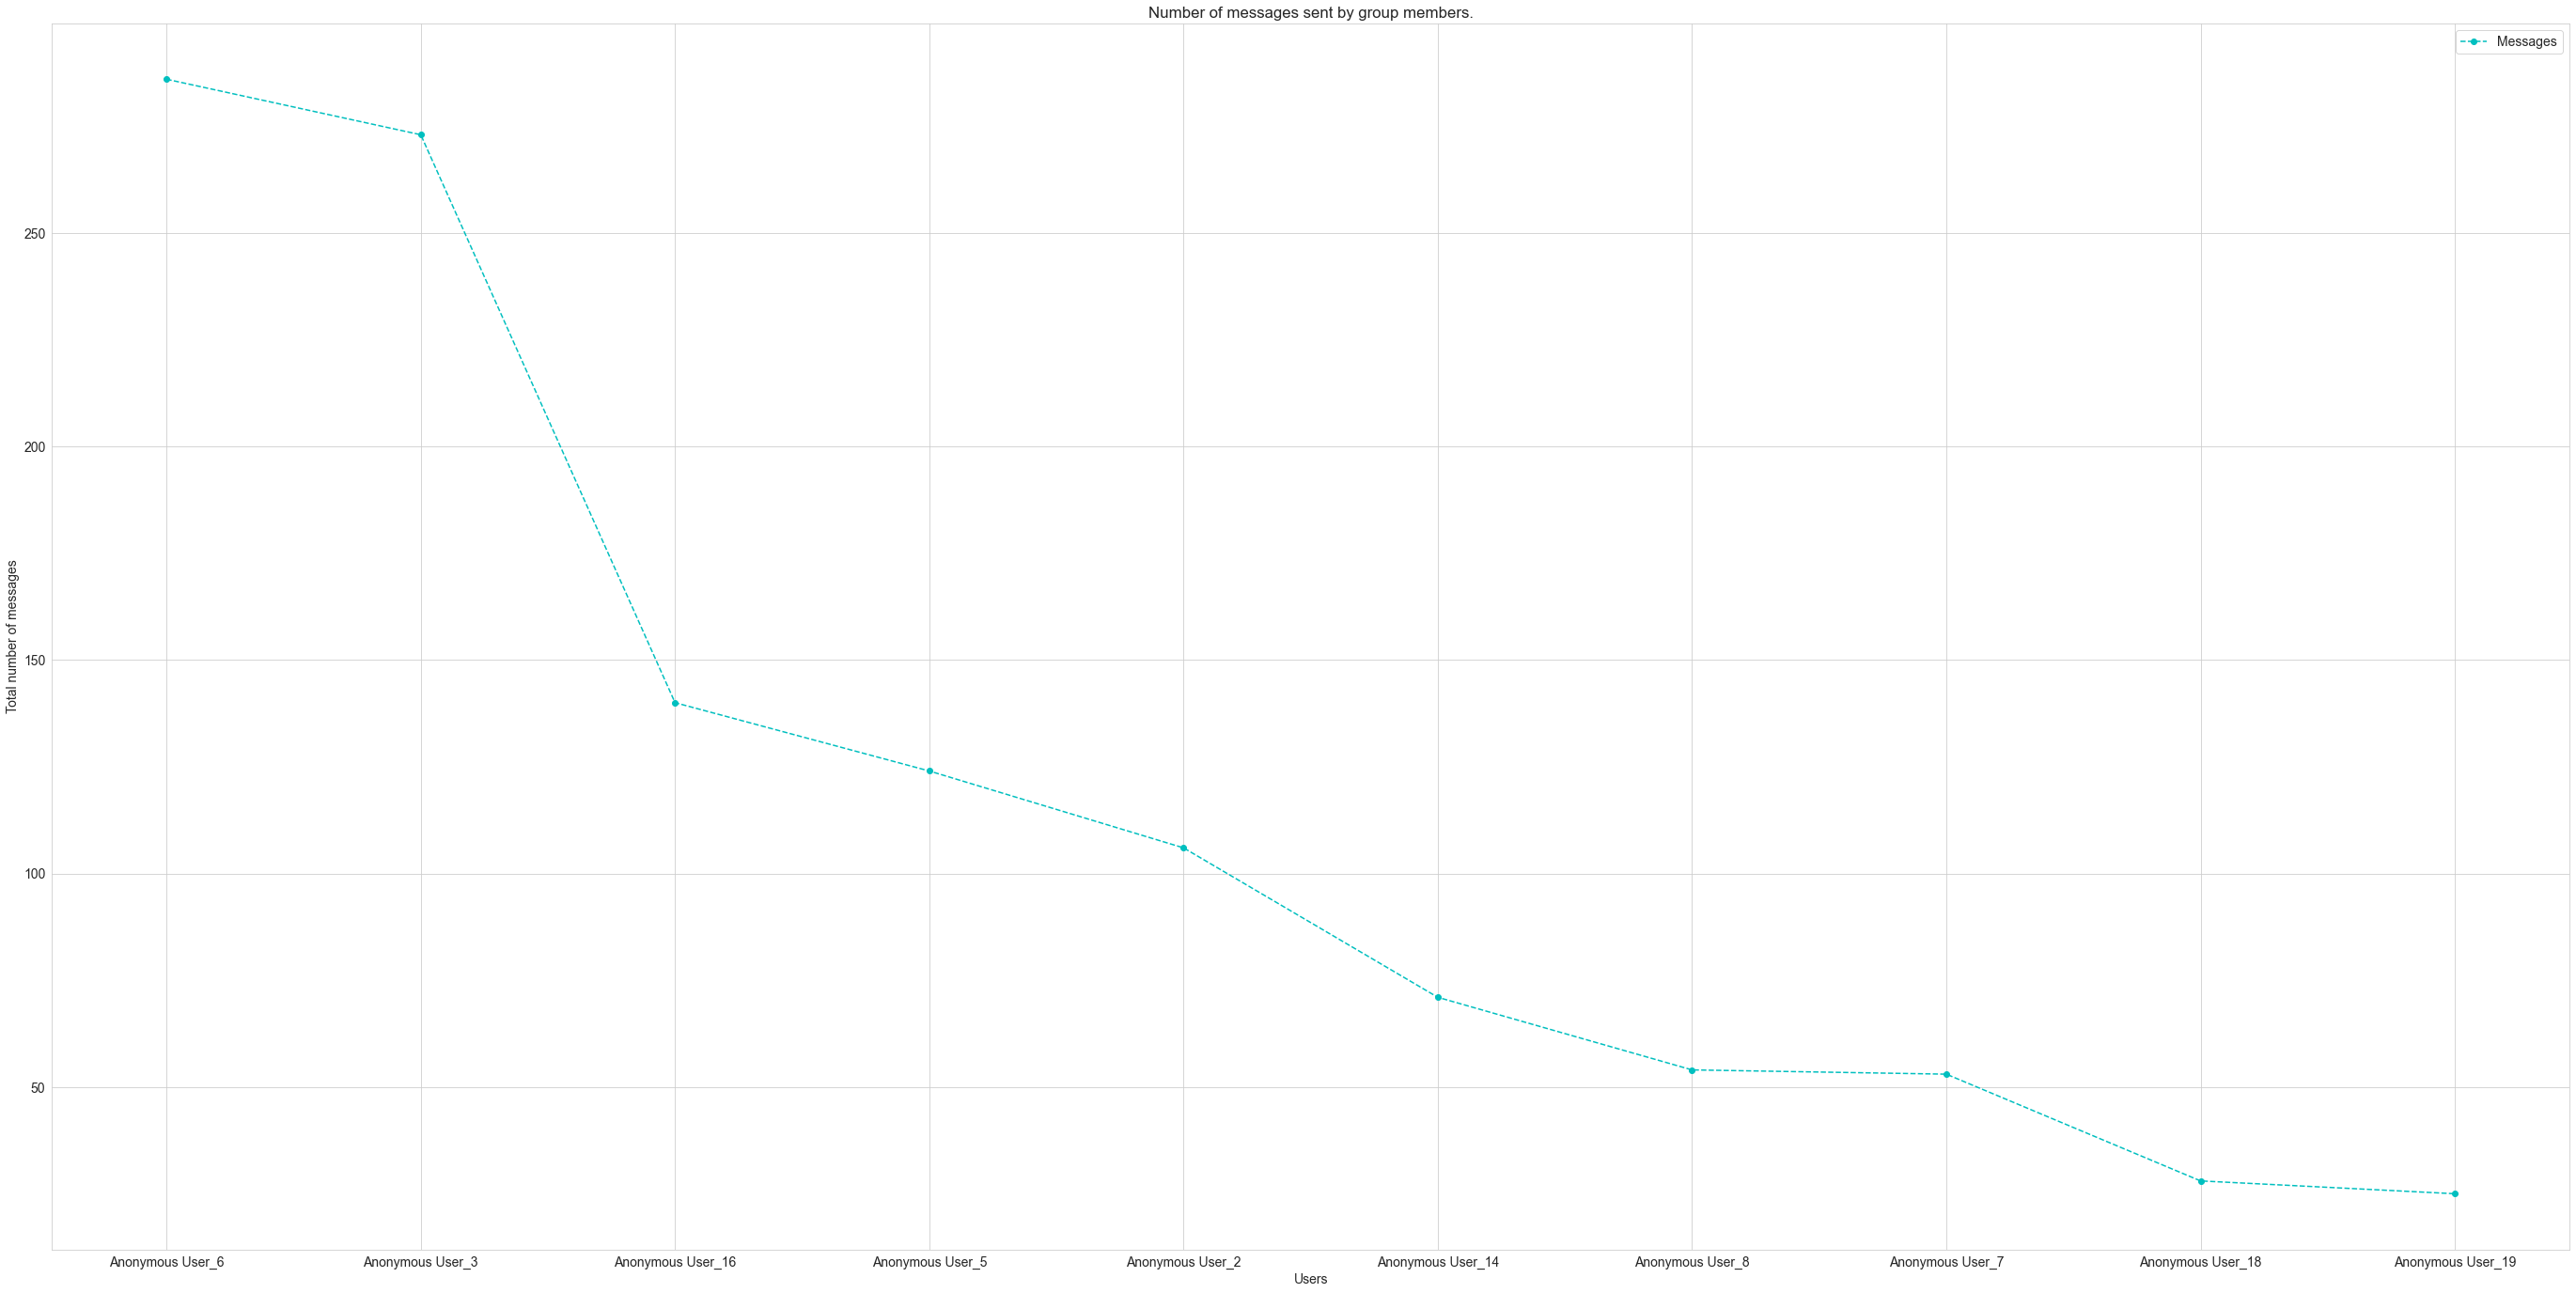

In [79]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(48, 24))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

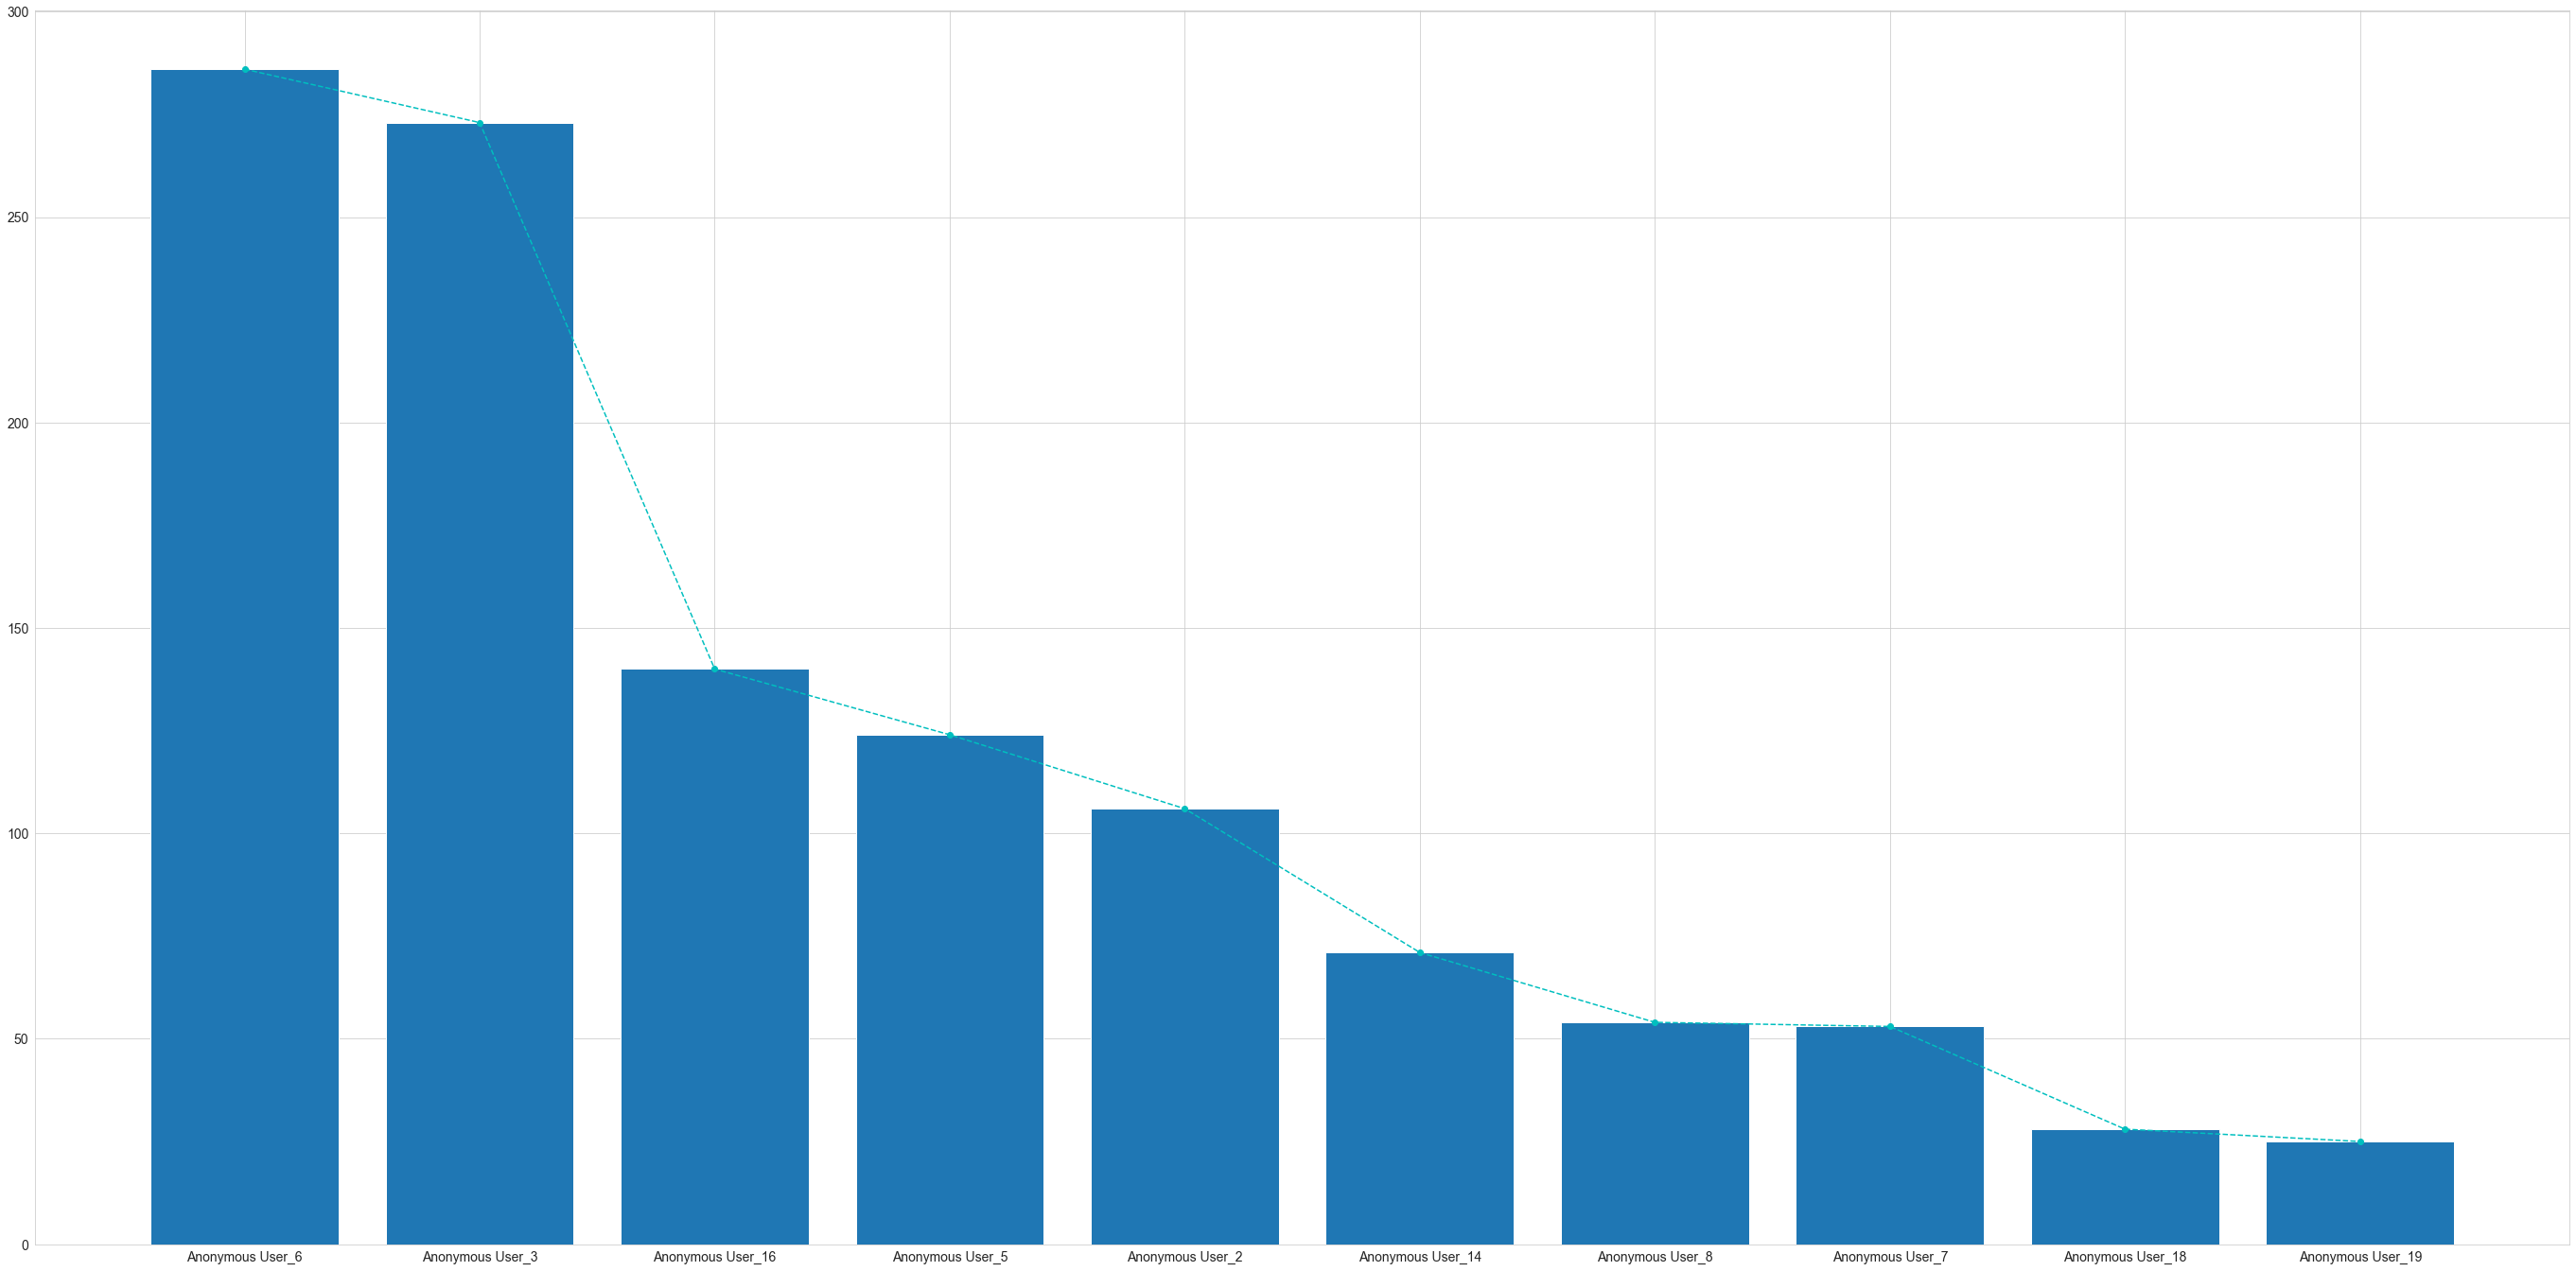

In [80]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(48, 24))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

In [81]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))      

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * len(top10df)
i, j = 0, 0
while i < len(top10df):
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

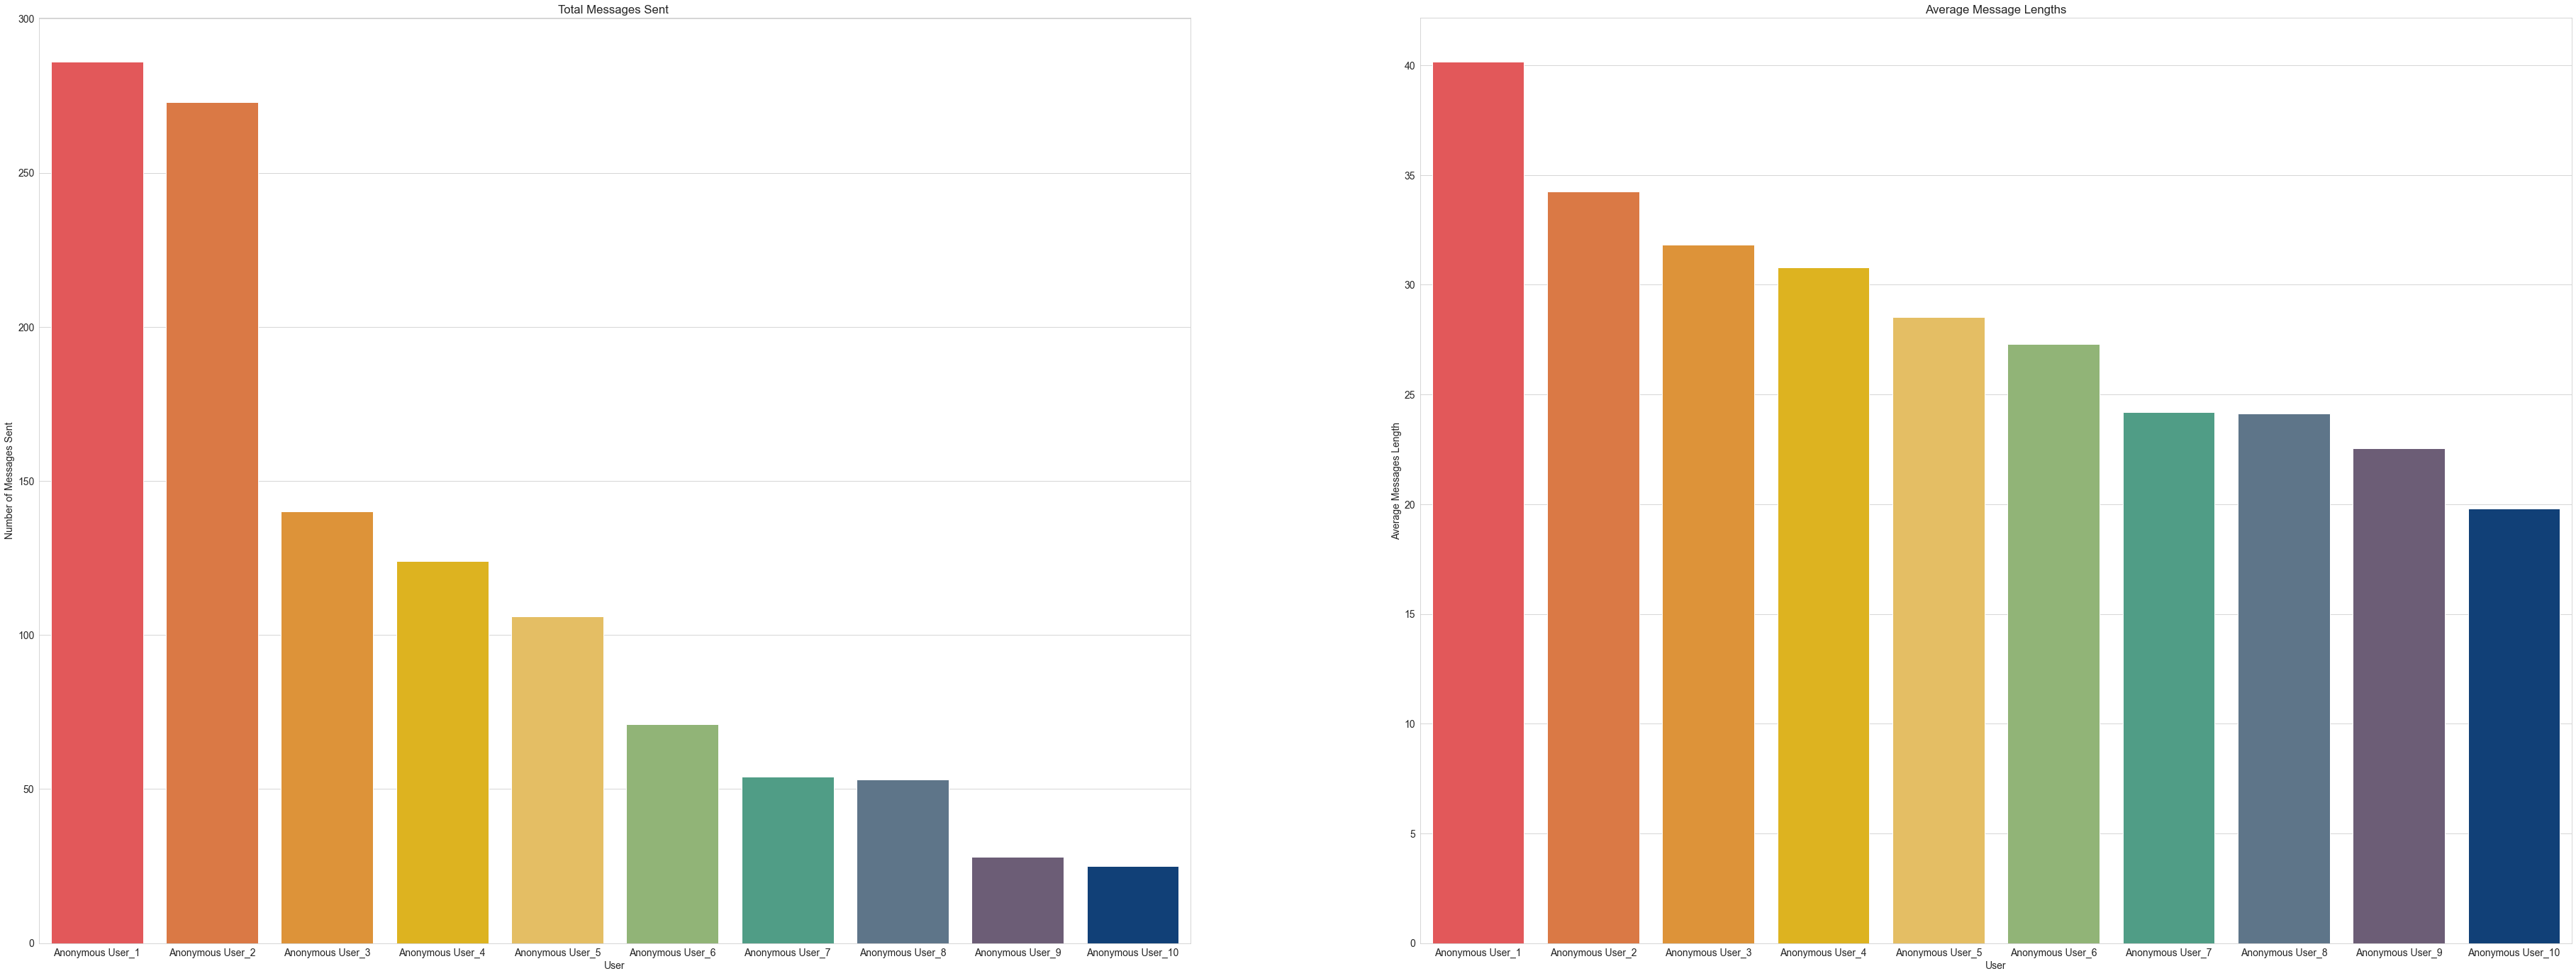

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

def anonymize_usernames(names_in_certain_order):
    '''Anonymizes the usernames and assigns a color to each user.'''
    
    colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
    
    order = list(names_in_certain_order)
    return_list = []
    
    for idx, name in enumerate(order):
        anonymized_name = f"Anonymous User_{idx+1}"
        return_list.append(anonymized_name)
        
    # Mapping anonymized usernames to colors
    color_dict = dict(zip(return_list, colors))
    
    return return_list, color_dict

names = top10df.initials

# Anonymize the usernames and get color mapping
anonymized_names, color_dict = anonymize_usernames(names)

# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(64, 24))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(anonymized_names, top10df.message, ax=axes[0], palette=color_dict.values())
axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')

# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(anonymized_names, top10df_msg.avg_message_length, ax=axes[1], palette=color_dict.values())
axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User')
axes[1].set_ylabel('Average Messages Length')

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format='svg')

plt.show()


In [85]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(len(top10media)):
        top10media.initials[i] = top10df.user[i]

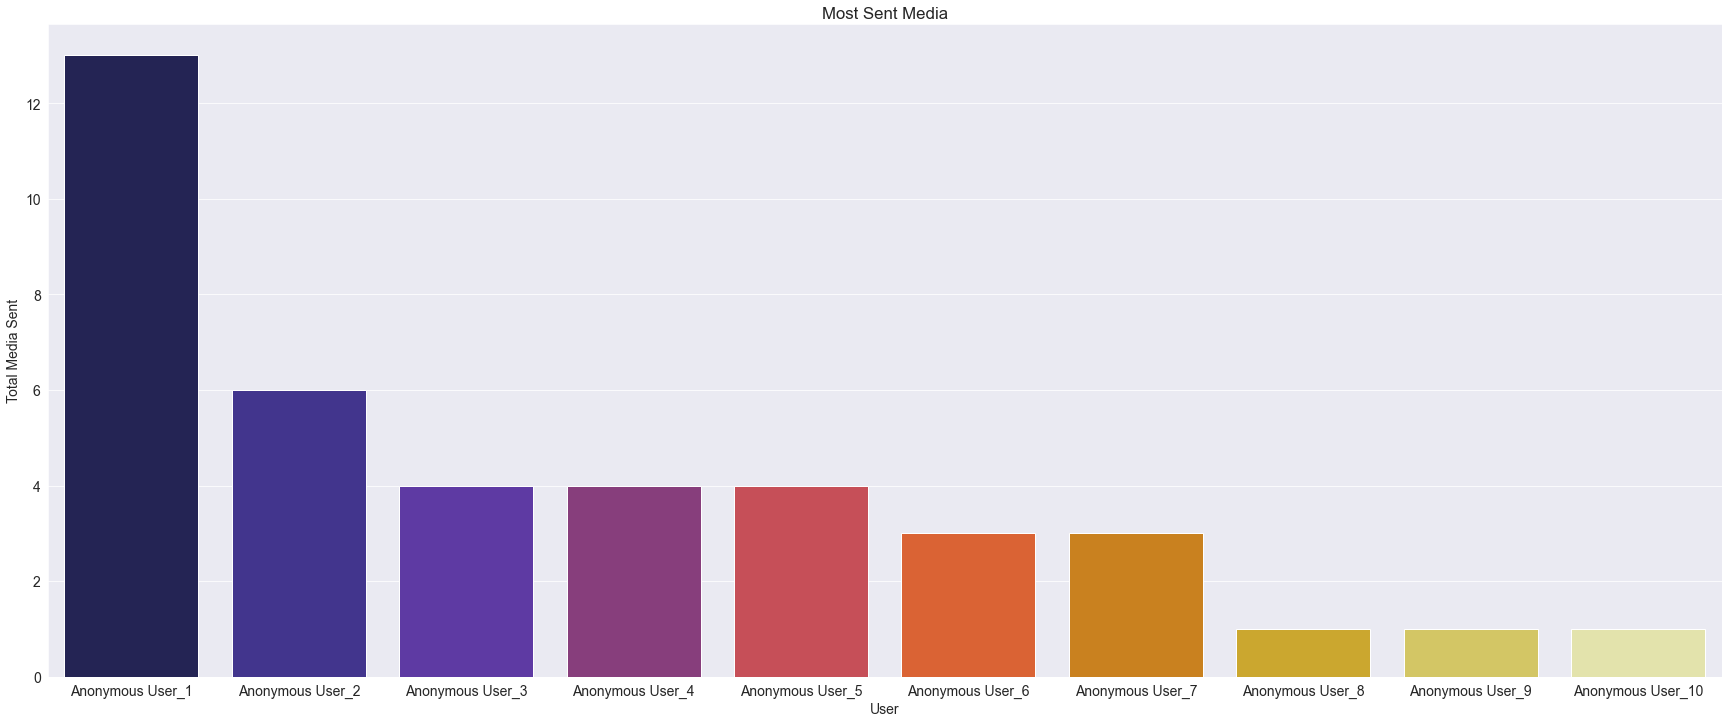

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

def anonymize_usernames(names_in_certain_order):
    '''Anonymizes the usernames and assigns a color to each user.'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for idx, name in enumerate(order):
        anonymized_name = f"Anonymous User_{idx+1}"
        return_list.append(anonymized_name)
        
    return return_list

names = top10media.initials

# Anonymize the usernames
anonymized_names = anonymize_usernames(names)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Increasing the figure size
plt.figure(figsize=(30, 12))

# Plotting a bar graph
sns.barplot(anonymized_names, top10media.media_sent, palette="CMRmap")

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent')

# Saving the plot
plt.savefig('top10media.svg', format='svg')

plt.show()


In [87]:
import emoji

def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(emoji.is_emoji(char) for char in word):
            emoji_list.append(word)
    return emoji_list

df['emoji'] = df["message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
print(emojis)


198


In [88]:
media_messages_df = df[df['message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)

total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
for i in emoji_dict:
  print(i)
  
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

('💀', 52)
('😭', 29)
('😂', 16)
('🤣', 11)
('🥲', 10)
('😔', 7)
('👍', 6)
('👀', 5)
('🥰', 5)
('😑', 4)
('😏', 4)
('📸', 4)
('❤️', 3)
('🙏', 3)
('🧐', 3)
('👍🏽', 2)
('🥺', 2)
('👉', 2)
('👈', 2)
('🤌', 2)
('🦭', 2)
('💪', 2)
('😅', 2)
('😎', 2)
('🧍\u200d♂️', 1)
('\U0001fae1', 1)
('🛐', 1)
('☹️', 1)
('🌚', 1)
('🔫', 1)
('😒', 1)
('😉', 1)
('🍑', 1)
('👋🏻', 1)
('👺', 1)
('\U0001f979', 1)
('\U0001fae3', 1)
('🍆', 1)
('🐐', 1)
('😮\u200d💨', 1)
('🙏🏻', 1)
('🤷\u200d♀️', 1)


In [89]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

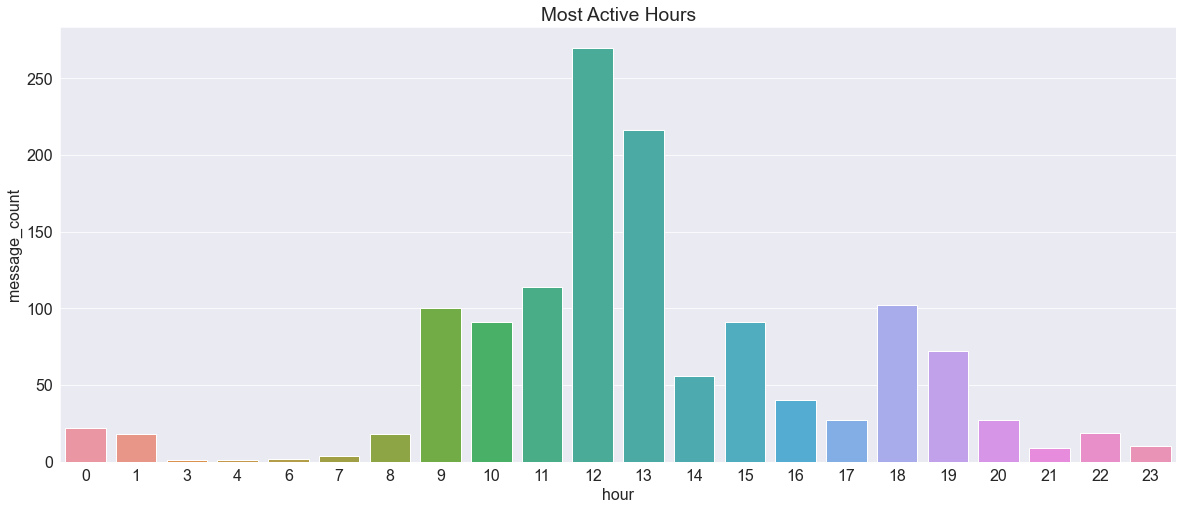

In [90]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)
plt.title('Most Active Hours');

# Saving the plots;
plt.savefig('most_active_hours.svg', format = 'svg')

In [91]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]

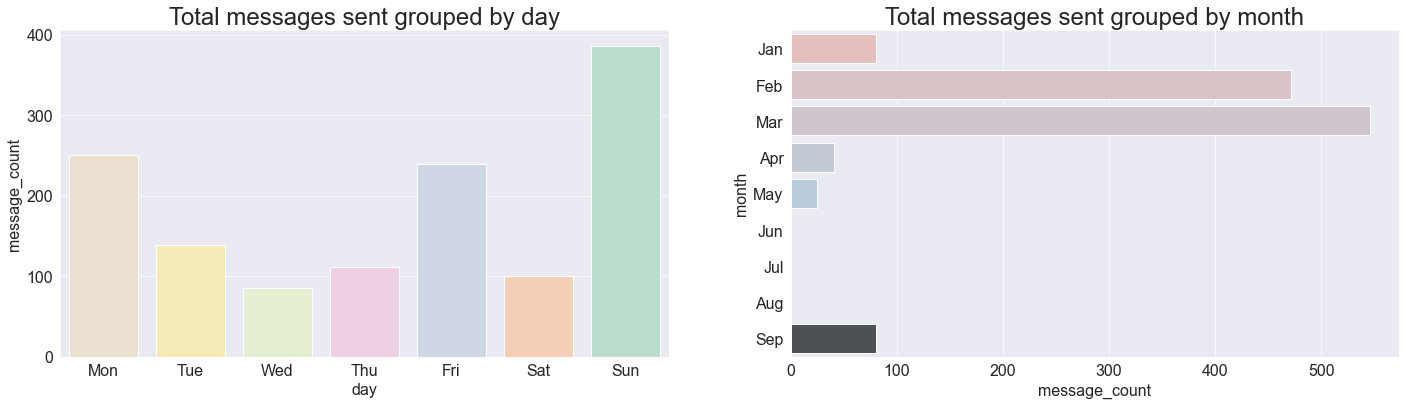

In [76]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(grouped_by_day.day, grouped_by_day.message_count, order=days, ax = axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y = grouped_by_month.month, x=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.svg', format = 'svg')

In [99]:
# Suppose you have an anonymized username
anonymized_username = "Anonymous User_2"

# Request the original username
original_username = get_original_username(anonymized_username, username_mapping)

# Print the result
print(f"The original username corresponding to '{anonymized_username}' is '{original_username}'")


The original username corresponding to 'Anonymous User_2' is 'Rithvik'


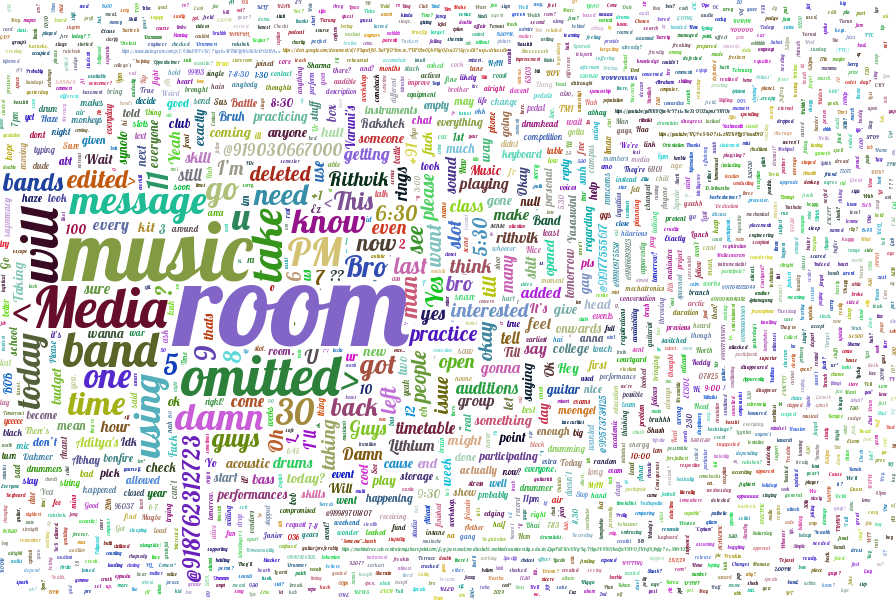

In [122]:
import pytagcloud
from pytagcloud import create_tag_image, make_tags
from collections import Counter

# Combine all messages into one large text string
text = " ".join(review for review in messages_df['message'])

# Define stopwords
stopwords = set(STOPWORDS)

# Create a Counter object to count word frequencies
word_counts = Counter(word for word in text.split() if word.lower() not in stopwords)

# Create tags for the top 100 words
tags = make_tags(word_counts.items(), maxsize=120)

# Generate the word cloud image
create_tag_image(tags, 'wordcloud.png', size=(900, 600), fontname='Lobster')

# Display the generated image
from IPython.display import Image
Image('wordcloud.png')